# Lets Classfiy Fruits 🍎🍊

In this Notebook I have tried to explain to use Tensorflow APIs to create a Image Classification CNN Model.
Also, I have tried to use Tensorflow Pipeline with prefetch data to train faster. 


## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
import tensorboard
from datetime import datetime
import os 
import matplotlib.image as mpimg
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import load_img, img_to_array
import pathlib
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

## Walk through the directory

In [2]:
for dirpath, dirnames, filenames in os.walk("../input/fruit-recognition"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in '../input/fruit-recognition'.
There are 1 directories and 0 images in '../input/fruit-recognition/test'.
There are 0 directories and 5641 images in '../input/fruit-recognition/test/test'.
There are 1 directories and 0 images in '../input/fruit-recognition/train'.
There are 33 directories and 0 images in '../input/fruit-recognition/train/train'.
There are 0 directories and 479 images in '../input/fruit-recognition/train/train/Orange'.
There are 0 directories and 738 images in '../input/fruit-recognition/train/train/Tomato'.
There are 0 directories and 490 images in '../input/fruit-recognition/train/train/Passion Fruit'.
There are 0 directories and 392 images in '../input/fruit-recognition/train/train/Cucumber Ripe'.
There are 0 directories and 490 images in '../input/fruit-recognition/train/train/Cactus fruit'.
There are 0 directories and 492 images in '../input/fruit-recognition/train/train/Pomegranate'.
There are 0 directories and 447 images in 

## Setup Path

In [3]:
train_path = "../input/fruit-recognition/train/train/"
test_path = "../input/fruit-recognition/test/test/"

In [4]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_path) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Apple Braeburn' 'Apple Granny Smith' 'Apricot' 'Avocado' 'Banana'
 'Blueberry' 'Cactus fruit' 'Cantaloupe' 'Cherry' 'Clementine' 'Corn'
 'Cucumber Ripe' 'Grape Blue' 'Kiwi' 'Lemon' 'Limes' 'Mango' 'Onion White'
 'Orange' 'Papaya' 'Passion Fruit' 'Peach' 'Pear' 'Pepper Green'
 'Pepper Red' 'Pineapple' 'Plum' 'Pomegranate' 'Potato Red' 'Raspberry'
 'Strawberry' 'Tomato' 'Watermelon']


In [5]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 100)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

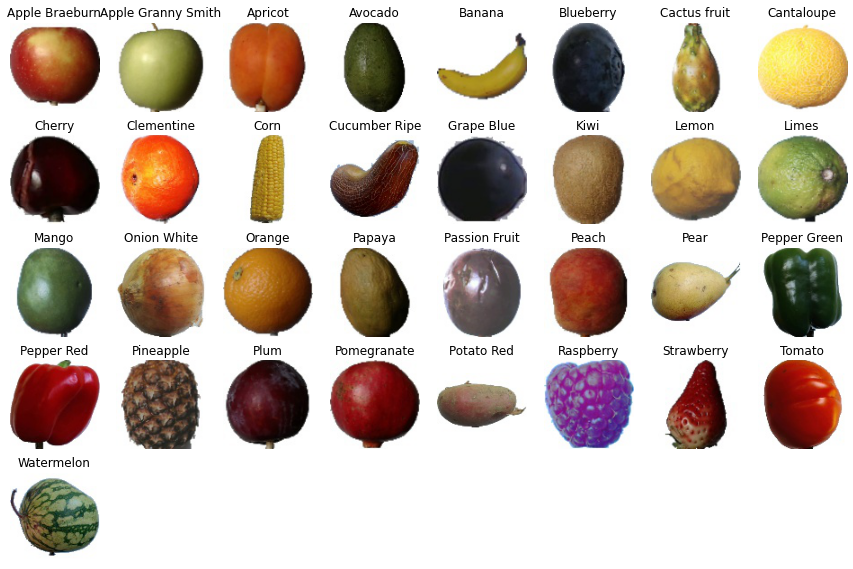

In [6]:
plt.figure(figsize = (15,10))
# View a random image from the training dataset for all classes
for i in range(33):
    plt.subplot(5,8,i+1)
    img = view_random_image(target_dir=train_path,
                        target_class=class_names[i])

## Prepare Data 

Let's prepare a pandas DataFrame with filepath, file name, and our target label from directory name.

In [7]:
train_val_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_val_data['path'].append(dirpath)
        train_val_data['filename'].append(f)
        train_val_data['label'].append(f.split('_')[0])

In [8]:
train_val_data_df = pd.DataFrame(train_val_data)
train_val_data_df.head()

,path,filename,label
0,../input/fruit-recognition/train/train/Orange,Orange_398.jpg,Orange
1,../input/fruit-recognition/train/train/Orange,Orange_20.jpg,Orange
2,../input/fruit-recognition/train/train/Orange,Orange_337.jpg,Orange
3,../input/fruit-recognition/train/train/Orange,Orange_190.jpg,Orange
4,../input/fruit-recognition/train/train/Orange,Orange_456.jpg,Orange


In [9]:
#Read test data and create a dataframe
test_data = {'path' : [],
       'filename': []}
for dirpath, dirnames, filenames in os.walk(test_path):
    for f in filenames:
        test_data['path'].append(dirpath)
        test_data['filename'].append(f)

In [10]:
test_data_df = pd.DataFrame(test_data)
test_data_df.head()

,path,filename
0,../input/fruit-recognition/test/test/,0664.jpg
1,../input/fruit-recognition/test/test/,1269.jpg
2,../input/fruit-recognition/test/test/,3863.jpg
3,../input/fruit-recognition/test/test/,2193.jpg
4,../input/fruit-recognition/test/test/,0733.jpg


Great, it looks good. Our path, filename, target label dataframe is prepared. 
Now we can split this data to create validation data also and play with it. 

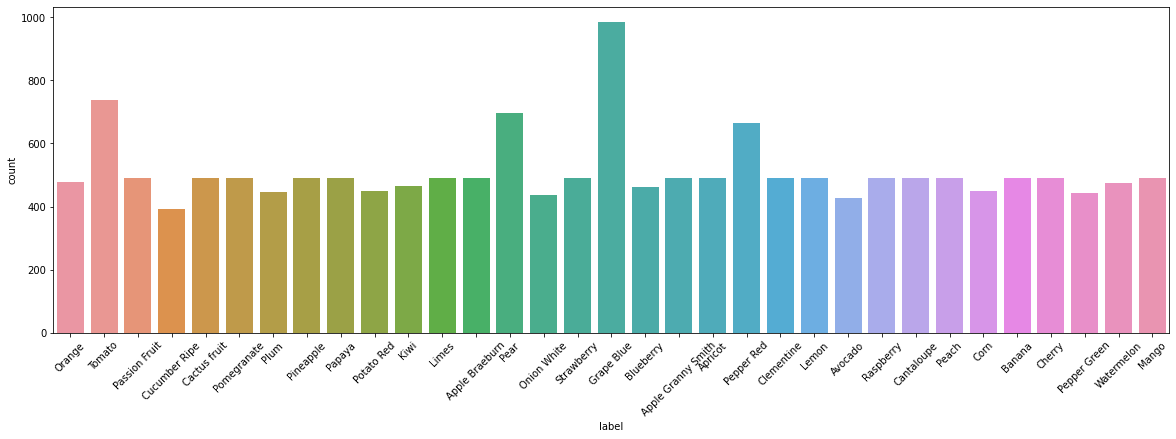

In [11]:
plt.figure(figsize = (20,6))
sns_cntplot = sns.countplot(x='label', data=train_val_data_df)
plt.xticks(rotation=45);

## Read Images and create numpy data array

In [12]:
images = []
label = [] 

for _, d in train_val_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    images.append(img_to_array(img))
    label.append(d['label'])

In [13]:
images = np.array(images)
labels = np.array(label)
print(f"Complete data images shape: {images.shape} and label shape: {labels.shape}")

Complete data images shape: (16854, 100, 100, 3) and label shape: (16854,)


In [14]:
test_images = []

for _, d in test_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    test_images.append(img_to_array(img))
    
test_images = np.array(test_images)
print(f"Test images shape: {test_images.shape} ")

Test images shape: (5641, 100, 100, 3) 


### Convert class names to labels

In [15]:
class_indices = dict(zip(class_names, range(len(class_names))))

labels_encoded = list(map(class_indices.get, labels))

#Convert to categorical data using tensorflow 
#labels to One-hot encoded
label_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(class_names), dtype='uint8')


### Split the Data into Training & Validation

In [16]:
train_im, valid_im, train_lab, valid_lab = train_test_split(images, label_categorical, test_size=0.20, 
                                                            stratify=label_categorical, 
                                                            random_state=40, shuffle = True)

In [17]:
print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (13483, 100, 100, 3)
new validation data shape:  (3371, 100, 100, 3)
validation labels shape:  (3371, 33)


In [18]:
print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices(test_images)

print ('check types; ', type(training_data), type(validation_data), type(test_data))

train im and label types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
check types;  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [19]:
### check using element_spec

print (training_data.element_spec)
print (validation_data.element_spec)

### as expected, tensors of image and original label shape


### create an iterator and turn it into numpy array 
train_iter = iter(training_data)
print(next(train_iter)[0].numpy(), '\n', next(train_iter)[1].numpy(), np.argmax(next(train_iter)[1].numpy()))

(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(33,), dtype=tf.uint8, name=None))
(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(33,), dtype=tf.uint8, name=None))
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [20]:
train_iter_im, train_iter_label = next(iter(training_data))
print (train_iter_im.numpy().shape, train_iter_label.numpy().shape)

(100, 100, 3) (33,)


In [21]:
train_iter_im1, train_iter_label1 = next(training_data.as_numpy_iterator())
print (train_iter_im1.shape, train_iter_label1.shape)

(100, 100, 3) (33,)


In [22]:
check_list = list(training_data.as_numpy_iterator())
print (len(check_list), check_list[1])

13483 (array([[[254., 255., 255.],
        [254., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[254., 255., 255.],
        [254., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [

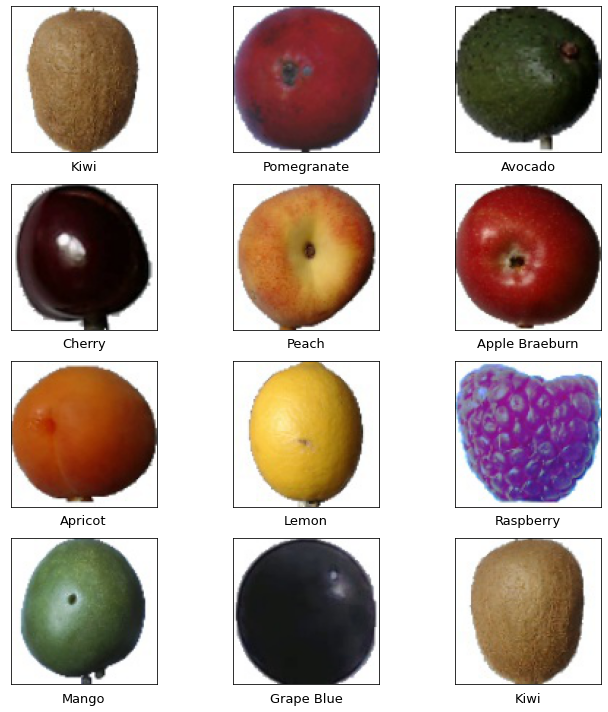

In [23]:

fig = plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0]/255.)
    plt.xlabel(class_names[np.argmax(check_list[i][1])], fontsize=13)
plt.tight_layout()    
plt.show()

## Data Pipeline using`tf.data` & Prefetching

In [24]:
rescale_data = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255.)
])

data_augmenation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
    #layers.experimental.preprocessing.RandomRotation(0.1)
])

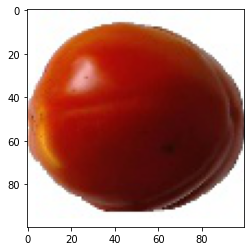

In [25]:
random_image_index = random.randint(0,len(train_im))
img = rescale_data(train_im[random_image_index])
img = data_augmenation(img)
plt.imshow(img)

In [26]:
BATCH_SIZE = 128 
AUTOTUNE = tf.data.AUTOTUNE 

def prepare(ds, shuffle=False, augment = False, test = False):
    if test:
        ds = ds.map(lambda x: (rescale_data(x)), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (rescale_data(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
    
    #batch the data 
    ds = ds.batch(BATCH_SIZE)
    
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmenation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [27]:
train_ds = prepare(training_data, shuffle = True, augment = True)
val_ds = prepare(validation_data)
test_ds = prepare(test_data, test=True)

## Prepare ML Model & Train

In [28]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=5, 
                          kernel_size = 3,
                          activation = "relu",
                          input_shape = (100,100,3)),
    tf.keras.layers.MaxPool2D(pool_size =2,
                             padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model_1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [29]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 5)         140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12005)             0         
_________________________________________________________________
dense (Dense)                (None, 33)                396198    
Total params: 396,338
Trainable params: 396,338
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Fit the model on training data 
history_1 = model_1.fit(train_ds,
                       epochs =5,
                       validation_data= val_ds,
                       callbacks = tensorboard_callback)

Epoch 1/5
106/106 [==============================] - 11s 94ms/step - loss: 1.0786 - accuracy: 0.7377 - val_loss: 0.2413 - val_accuracy: 0.9413
Epoch 2/5
106/106 [==============================] - 8s 71ms/step - loss: 0.1060 - accuracy: 0.9822 - val_loss: 0.0468 - val_accuracy: 0.9935
Epoch 3/5
106/106 [==============================] - 8s 77ms/step - loss: 0.0288 - accuracy: 0.9978 - val_loss: 0.0220 - val_accuracy: 0.9979
Epoch 4/5
106/106 [==============================] - 8s 72ms/step - loss: 0.0131 - accuracy: 0.9993 - val_loss: 0.0148 - val_accuracy: 0.9988
Epoch 5/5
106/106 [==============================] - 8s 70ms/step - loss: 0.0082 - accuracy: 0.9999 - val_loss: 0.0100 - val_accuracy: 0.9982


## Evaluate the model 

In [55]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
model_1.evaluate(val_ds)

27/27 [==============================] - 1s 19ms/step - loss: 0.0100 - accuracy: 0.9982


[0.009989376179873943, 0.9982200860977173]

<AxesSubplot:>

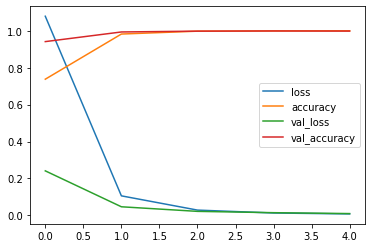

In [35]:
#loss and accuracy plot 
pd.DataFrame(history_1.history).plot()

## Prepare prediction on Validation data

In [36]:
y_pred = model_1.predict(val_ds)

In [37]:
y_pred[:1]

array([[1.7579058e-08, 5.8329083e-06, 8.2288912e-11, 3.4884965e-06,
        6.6345215e-06, 4.9377533e-12, 1.6368821e-06, 2.0893530e-12,
        5.6626435e-15, 4.1952278e-10, 2.8224853e-10, 6.9378001e-07,
        1.2927166e-09, 2.4191839e-05, 6.3347144e-08, 8.2004759e-13,
        3.7059142e-06, 1.5567228e-05, 1.8762000e-14, 9.9988210e-01,
        1.3506053e-11, 1.1232040e-06, 1.3367381e-07, 8.1109739e-08,
        5.1661195e-09, 1.1772677e-09, 2.8959628e-13, 5.2381868e-08,
        1.6797798e-06, 2.4310629e-12, 5.2939249e-05, 5.5164112e-08,
        1.4157996e-08]], dtype=float32)

Our model prediction are in form of probability since we used softmax activation function in output layer. For finding the class we need to find max probability assigned to the class using argmax().

In [38]:
y_pred.shape  #shape of y_pred

(3371, 33)

In [39]:
y_pred = tf.argmax(y_pred, axis=1) # Get y_pred classes 

In [40]:
y_true = np.argmax(valid_lab,axis=1)

In [41]:
y_true, y_pred

(array([19, 12, 12, ..., 32,  6, 22]),
 <tf.Tensor: shape=(3371,), dtype=int64, numpy=array([19, 12, 12, ..., 32,  6, 22])>)

In [42]:
len(y_pred), len(y_true)

(3371, 3371)

Great, now both y_pred and y_true are in same format. We can now compare to find the accuracy and create confusion matrix.

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 99,   0,   0, ...,   0,   0,   0],
       [  0,  99,   0, ...,   0,   0,   0],
       [  0,   0,  99, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  97,   0,   0],
       [  0,   0,   0, ...,   0, 148,   0],
       [  0,   0,   0, ...,   0,   0,  94]])

<AxesSubplot:>

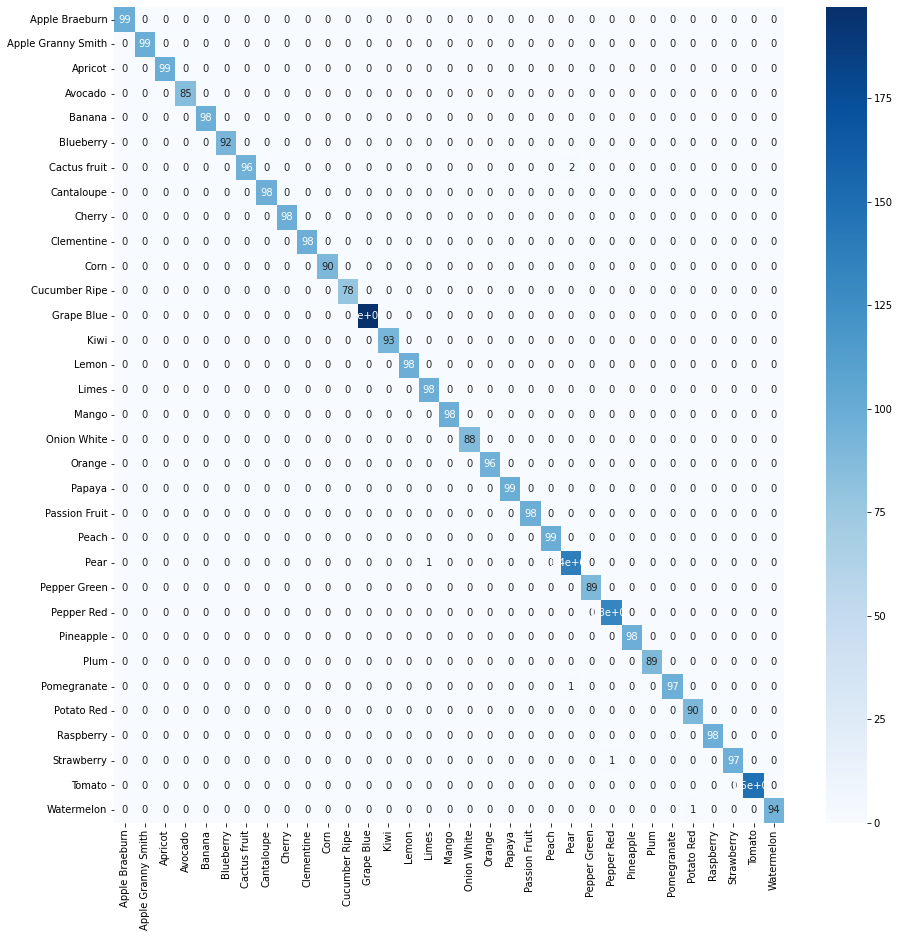

In [44]:
plt.figure(figsize = (15,15))
sns.heatmap(pd.DataFrame(cm, index= class_names, columns = class_names), annot = True, cmap="Blues")

## Prediction on test data

In [45]:
predictions = model_1.predict(test_ds)

In [46]:
predictions.shape

(5641, 33)

In [47]:
predictions = class_names[tf.argmax(predictions, axis=1)] # Get classes 
predictions[:5]

array(['Orange', 'Pear', 'Potato Red', 'Apricot', 'Potato Red'],
      dtype='<U18')

In [48]:
predictions.shape

(5641,)

## Prepare Submission file

In [ ]:
submission = pd.read_csv("../input/fruit-recognition/sampleSubmission.csv")
submission.head(2)

In [ ]:
test_data_df.head() # We already have this data. lets take filename from this

In [ ]:
submission['id'] = test_data_df['filename']
submission['label'] = predictions

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv",index=False)

 <center><b>👍Go through the notebook and upvote if you like the work. Comment for any suggestion or queries.👍</b></center>

References: 
* https://www.tensorflow.org/tutorials/images/data_augmentation
* https://www.tensorflow.org/tutorials/images/cnn
* https://www.tensorflow.org/guide/data_performance